### Data Pre-processing

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
df = pd.read_csv("spacex_dataset.csv")

In [3]:
df.head()

,mission_name,Rocket Type,Reusability,Payload Mass (kg),Payload Type,Orbit,Country,Launch Success,launch_date,launch_year
0,falconsat,Falcon 1,False,20.000000,Satellite,LEO,Marshall Islands,0.0,2006-03-24 22:30:00+00:00,2006
1,demosat,Falcon 1,False,7834.885404,Satellite,LEO,Marshall Islands,0.0,2007-03-21 01:10:00+00:00,2007
2,trailblazer,Falcon 1,False,7834.885404,Satellite,LEO,Marshall Islands,0.0,2008-08-03 03:34:00+00:00,2008
3,ratsat,Falcon 1,False,165.000000,Satellite,LEO,Marshall Islands,1.0,2008-09-28 23:15:00+00:00,2008
4,razaksat,Falcon 1,False,200.000000,Satellite,LEO,Marshall Islands,1.0,2009-07-13 03:35:00+00:00,2009


In [4]:
df.shape

(186, 10)

In [5]:
df.isnull().sum()

mission_name         0
Rocket Type          0
Reusability          0
Payload Mass (kg)    0
Payload Type         0
Orbit                0
Country              0
Launch Success       0
launch_date          0
launch_year          0
dtype: int64

No missing values

In [6]:
df.dtypes

mission_name          object
Rocket Type           object
Reusability             bool
Payload Mass (kg)    float64
Payload Type          object
Orbit                 object
Country               object
Launch Success       float64
launch_date           object
launch_year            int64
dtype: object

In [7]:
df['launch_date'] = pd.to_datetime(df['launch_date'])
df.dtypes

mission_name                      object
Rocket Type                       object
Reusability                         bool
Payload Mass (kg)                float64
Payload Type                      object
Orbit                             object
Country                           object
Launch Success                   float64
launch_date          datetime64[ns, UTC]
launch_year                        int64
dtype: object

In [8]:
# Extracting month and day from the date
df['launch_month'] = df['launch_date'].dt.month
df['launch_day_of_week'] = df['launch_date'].dt.dayofweek

In [9]:
df.head()

,mission_name,Rocket Type,Reusability,Payload Mass (kg),Payload Type,Orbit,Country,Launch Success,launch_date,launch_year,launch_month,launch_day_of_week
0,falconsat,Falcon 1,False,20.000000,Satellite,LEO,Marshall Islands,0.0,2006-03-24 22:30:00+00:00,2006,3,4
1,demosat,Falcon 1,False,7834.885404,Satellite,LEO,Marshall Islands,0.0,2007-03-21 01:10:00+00:00,2007,3,2
2,trailblazer,Falcon 1,False,7834.885404,Satellite,LEO,Marshall Islands,0.0,2008-08-03 03:34:00+00:00,2008,8,6
3,ratsat,Falcon 1,False,165.000000,Satellite,LEO,Marshall Islands,1.0,2008-09-28 23:15:00+00:00,2008,9,6
4,razaksat,Falcon 1,False,200.000000,Satellite,LEO,Marshall Islands,1.0,2009-07-13 03:35:00+00:00,2009,7,0


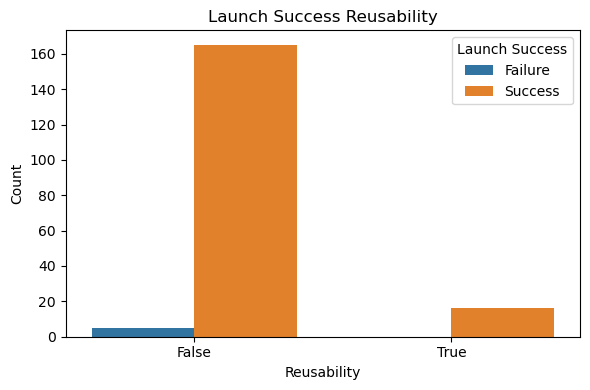

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Reusability', hue='Launch Success')
plt.title('Launch Success Reusability')
plt.ylabel('Count')
plt.legend(title='Launch Success', labels=['Failure','Success'])
plt.tight_layout()
plt.show()

- Reusable Rockets = True, have 100% Success Rate
- Majority of Rockets fall into Non-Reusable Rockets = False
- There are few non-reusable rockets that have faliure represented by Blue.

## Launch Success Prediction

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,roc_curve,auc
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from collections import Counter

In [12]:
df.columns

Index(['mission_name', 'Rocket Type', 'Reusability', 'Payload Mass (kg)',
       'Payload Type', 'Orbit', 'Country', 'Launch Success', 'launch_date',
       'launch_year', 'launch_month', 'launch_day_of_week'],
      dtype='object')

In [13]:
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

In [14]:
df.columns

Index(['mission_name', 'rocket_type', 'reusability', 'payload_mass_(kg)',
       'payload_type', 'orbit', 'country', 'launch_success', 'launch_date',
       'launch_year', 'launch_month', 'launch_day_of_week'],
      dtype='object')

In [15]:
features = ['reusability', 'payload_mass_(kg)', 'rocket_type', 'payload_type','orbit', 'country', 'launch_month', 'launch_day_of_week']
target = 'launch_success'

X = df[features]
y = df[target]

In [16]:
df.dtypes

mission_name                       object
rocket_type                        object
reusability                          bool
payload_mass_(kg)                 float64
payload_type                       object
orbit                              object
country                            object
launch_success                    float64
launch_date           datetime64[ns, UTC]
launch_year                         int64
launch_month                        int32
launch_day_of_week                  int32
dtype: object

In [17]:
categorical_cols = X.select_dtypes(include=['object','bool']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

In [18]:
preprocessor = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='median'), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

X_preprocessed = preprocessor.fit_transform(X)

In [19]:
launch_counts = df['launch_success'].value_counts().sort_index()

print(f" Successful Launches: {int(launch_counts.get(1.0, 0))}")
print(f" Failed Launches    : {int(launch_counts.get(0.0, 0))}")

 Successful Launches: 181
 Failed Launches    : 5


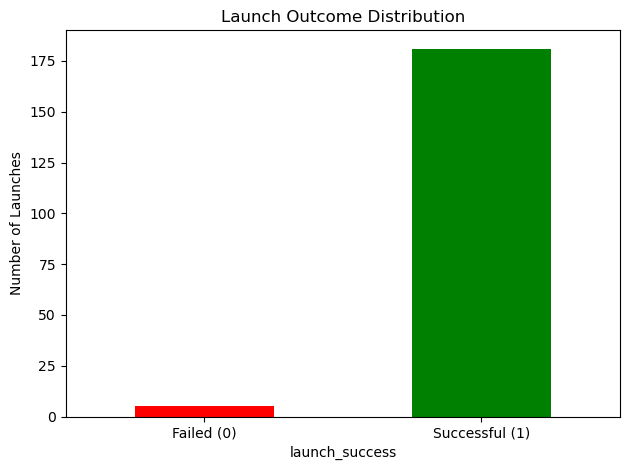

In [20]:
launch_counts.plot(kind='bar', color=['red', 'green'])
plt.xticks(ticks=[0, 1], labels=['Failed (0)', 'Successful (1)'], rotation=0)
plt.ylabel("Number of Launches")
plt.title("Launch Outcome Distribution")
plt.tight_layout()
plt.show()


Data is highly imbalanced

In [21]:
smt = SMOTETomek(
    sampling_strategy='auto',
    random_state=42,
    smote=SMOTE(k_neighbors=2, random_state=42)
)

In [22]:
X_balanced, y_balanced = smt.fit_resample(X_preprocessed, y)

print("Original class distribution:", Counter(y))
print("Balanced class distribution:", Counter(y_balanced))

Original class distribution: Counter({1.0: 181, 0.0: 5})
Balanced class distribution: Counter({0.0: 159, 1.0: 159})


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [24]:
def plot_conf_matrix(cm, model_name):
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Failure (0)', 'Success (1)'],
                yticklabels=['Failure (0)', 'Success (1)'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


In [25]:
def plot_roc_curve(model, X_test, y_test, model_name):
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f'{model_name} - ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, preprocessor, model_name):
    # Only works for tree-based models
    try:
        ohe_features = preprocessor.named_transformers_['cat'].get_feature_names_out()
        full_features = numeric_cols + list(ohe_features)
        importances = model.feature_importances_

        feat_imp_df = pd.DataFrame({'feature': full_features, 'importance': importances})
        feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False).head(15)

        plt.figure(figsize=(8, 6))
        sns.barplot(data=feat_imp_df, x='importance', y='feature', palette='viridis')
        plt.title(f'{model_name} - Top 15 Feature Importances')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
    except:
        print(f"[{model_name}] does not support feature_importances_ or failed to plot.")


### Training and Evaluation 

#### 1. Linear Models

In [26]:
linear_results = []

In [27]:
## Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)


In [28]:
print("\n Logistic Regression Results:")
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
print("ROC AUC:", roc_auc_score(y_test, y_pred_log))


 Logistic Regression Results:
[[23  9]
 [ 3 29]]
              precision    recall  f1-score   support

         0.0       0.88      0.72      0.79        32
         1.0       0.76      0.91      0.83        32

    accuracy                           0.81        64
   macro avg       0.82      0.81      0.81        64
weighted avg       0.82      0.81      0.81        64

ROC AUC: 0.8125


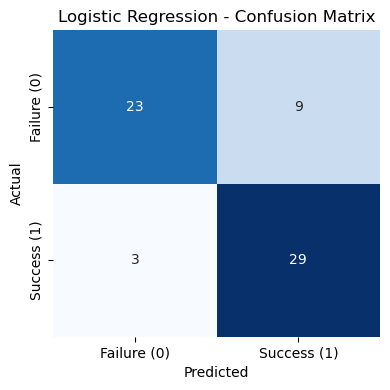

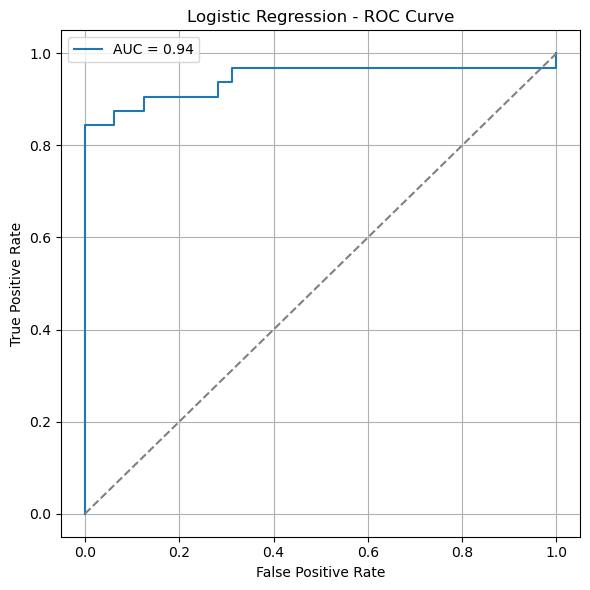

In [29]:
plot_conf_matrix(confusion_matrix(y_test, y_pred_log), "Logistic Regression")
plot_roc_curve(log_model, X_test, y_test, "Logistic Regression")

- The ROC Curve shows the trade-off between True Positive Rate and False Positive Rate for all thresholds.  
- The curve is close to the top-left corner, indicating strong classification performance.  
- With an AUC of **0.94**, the Logistic Regression model is performing **excellent** at distinguishing launch outcomes.  

In [30]:
linear_results.append({
    'Model': 'Logistic Regression',
    'Accuracy': log_model.score(X_test, y_test),
    'AUC': roc_auc_score(y_test, y_pred_log)
})

In [31]:
## Ridge Classifier
ridge_model = RidgeClassifier()
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

In [32]:
print("\n Ridge Classifier Results:")
print(confusion_matrix(y_test, y_pred_ridge))
print(classification_report(y_test, y_pred_ridge))


 Ridge Classifier Results:
[[19 13]
 [ 8 24]]
              precision    recall  f1-score   support

         0.0       0.70      0.59      0.64        32
         1.0       0.65      0.75      0.70        32

    accuracy                           0.67        64
   macro avg       0.68      0.67      0.67        64
weighted avg       0.68      0.67      0.67        64



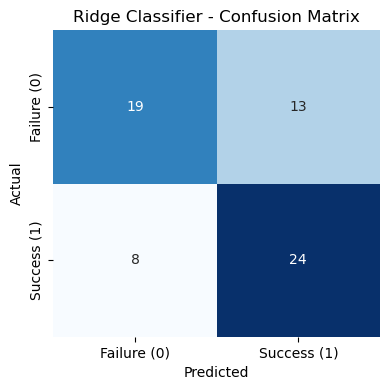

In [33]:
ridge_auc = roc_auc_score(y_test, y_pred_ridge)
plot_conf_matrix(confusion_matrix(y_test, y_pred_ridge), "Ridge Classifier")


In [34]:
linear_results.append({
    'Model': 'Ridge Classifier',
    'Accuracy': ridge_model.score(X_test, y_test),
    'AUC': ridge_auc
})


#### 2. Tree-Based Models

In [35]:
from sklearn.tree import DecisionTreeClassifier

In [36]:
tree_results = []

In [37]:
# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

In [38]:
print("\n Decision Tree Results:")
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))
print("ROC AUC:", roc_auc_score(y_test, y_pred_dt))


 Decision Tree Results:
[[29  3]
 [ 1 31]]
              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94        32
         1.0       0.91      0.97      0.94        32

    accuracy                           0.94        64
   macro avg       0.94      0.94      0.94        64
weighted avg       0.94      0.94      0.94        64

ROC AUC: 0.9375


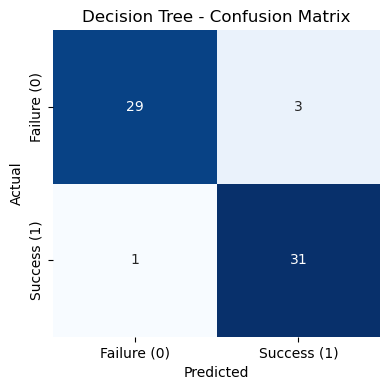

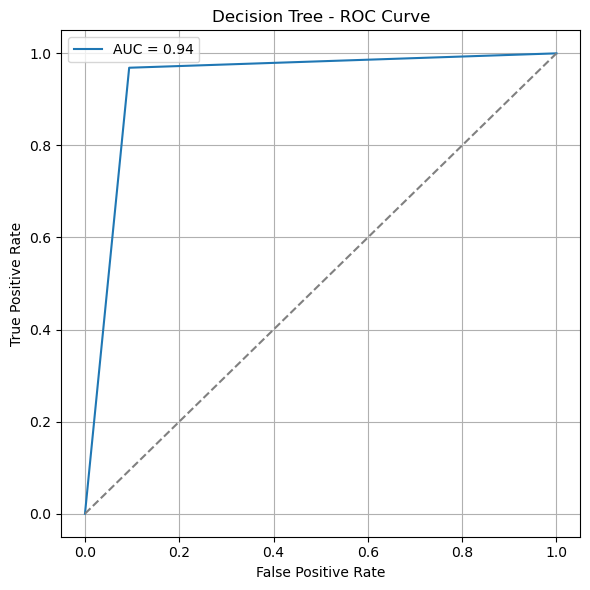

C:\Users\dhyan\AppData\Local\Temp\ipykernel_13844\1161178519.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x='importance', y='feature', palette='viridis')


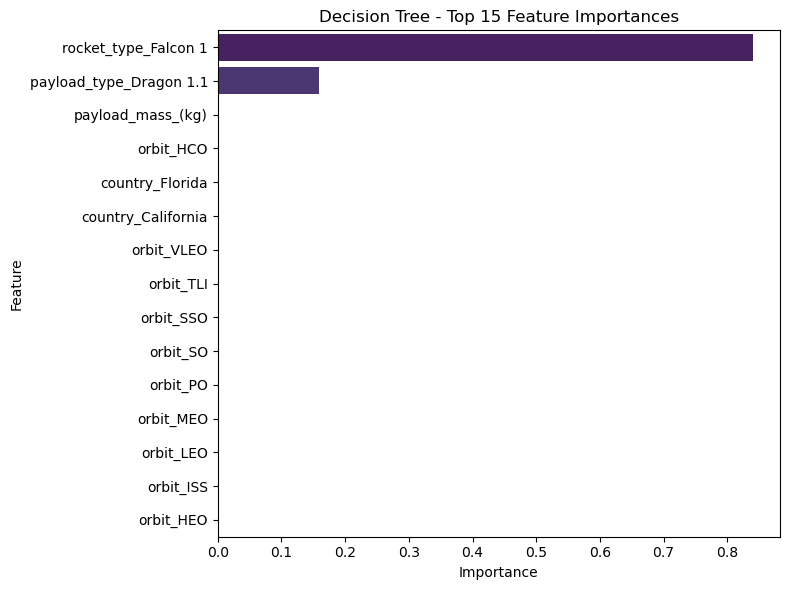

In [39]:
plot_conf_matrix(confusion_matrix(y_test, y_pred_dt), "Decision Tree")
plot_roc_curve(dt_model, X_test, y_test, "Decision Tree")
plot_feature_importance(dt_model, preprocessor, "Decision Tree")


- The plot shows the ROC curve for a Decision Tree classifier with an AUC of 0.94.  
- AUC (Area Under Curve) of 0.94 indicates excellent model performance in distinguishing between classes.  
- The curve's sharp rise toward the top-left corner reflects a high true positive rate with a low false positive rate.

In [40]:
tree_results.append({
    'Model': 'Decision Tree',
    'Accuracy': dt_model.score(X_test, y_test),
    'AUC': roc_auc_score(y_test, y_pred_dt)
})

In [41]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [42]:
print("\nRandom Forest Results:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_pred_rf))



Random Forest Results:
[[29  3]
 [ 1 31]]
              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94        32
         1.0       0.91      0.97      0.94        32

    accuracy                           0.94        64
   macro avg       0.94      0.94      0.94        64
weighted avg       0.94      0.94      0.94        64

ROC AUC: 0.9375


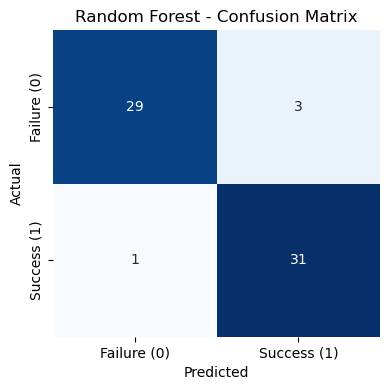

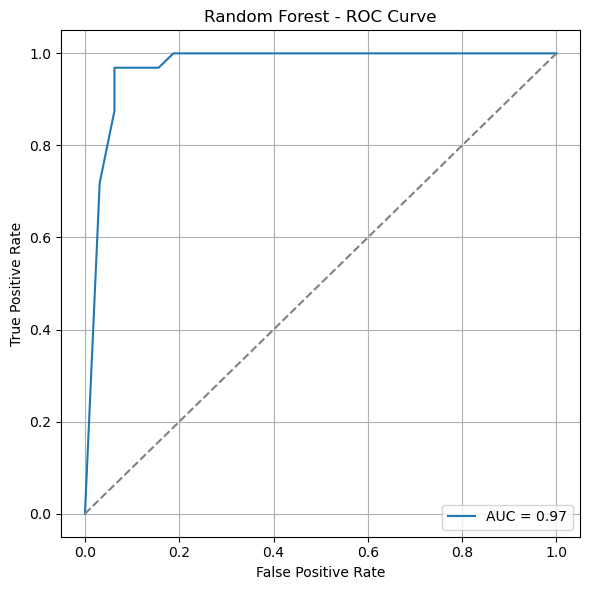

C:\Users\dhyan\AppData\Local\Temp\ipykernel_13844\1161178519.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x='importance', y='feature', palette='viridis')


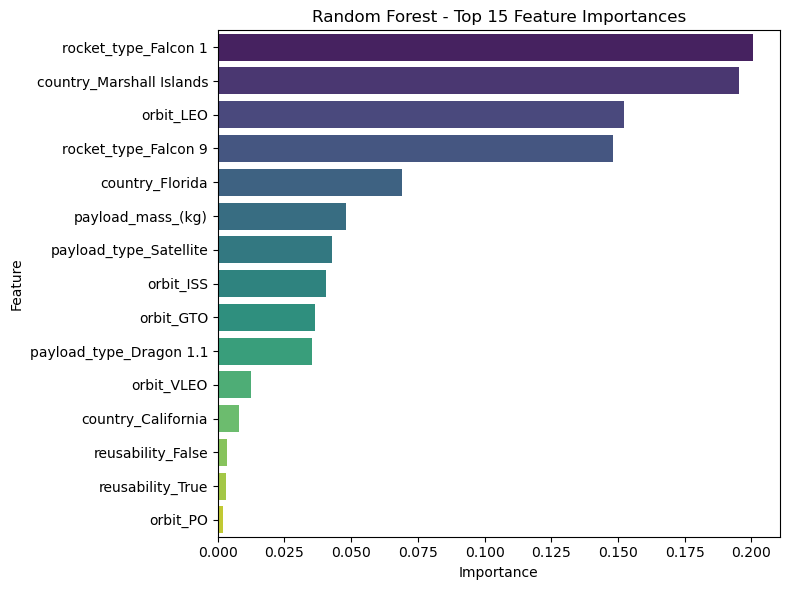

In [43]:
plot_conf_matrix(confusion_matrix(y_test, y_pred_rf), "Random Forest")
plot_roc_curve(rf_model, X_test, y_test, "Random Forest")
plot_feature_importance(rf_model, preprocessor, "Random Forest")


- The ROC Curve for Random Forest shows an almost perfect separation between the classes.  
- The curve hugs the top-left corner, indicating **very high sensitivity and specificity**.  
- With an AUC of **0.97**, the model delivers **outstanding performance** in predicting launch success.  

#### 3. Boosting Models

In [44]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [45]:
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier

In [46]:
boosting_results = []


In [47]:
## 1. XG boost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

c:\Users\dhyan\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:38:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [48]:
print("\nXGBoost Results:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_pred_xgb))


XGBoost Results:
[[30  2]
 [ 1 31]]
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95        32
         1.0       0.94      0.97      0.95        32

    accuracy                           0.95        64
   macro avg       0.95      0.95      0.95        64
weighted avg       0.95      0.95      0.95        64

ROC AUC: 0.953125


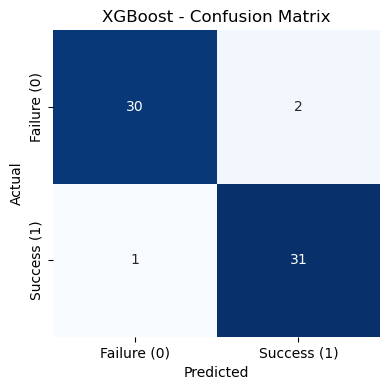

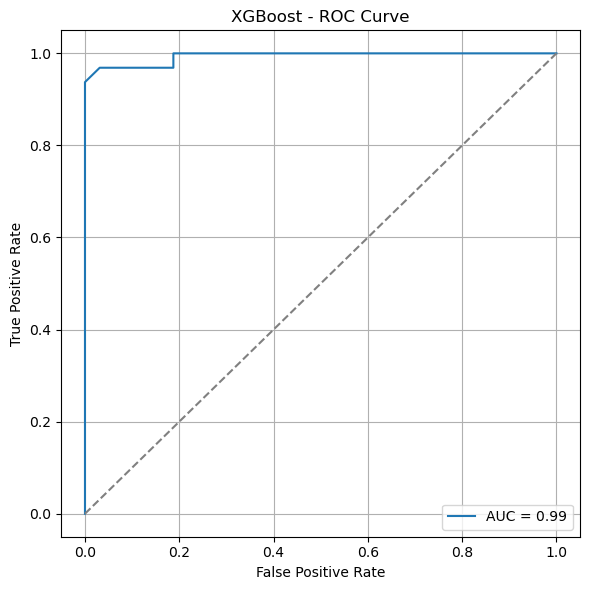

C:\Users\dhyan\AppData\Local\Temp\ipykernel_13844\1161178519.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x='importance', y='feature', palette='viridis')


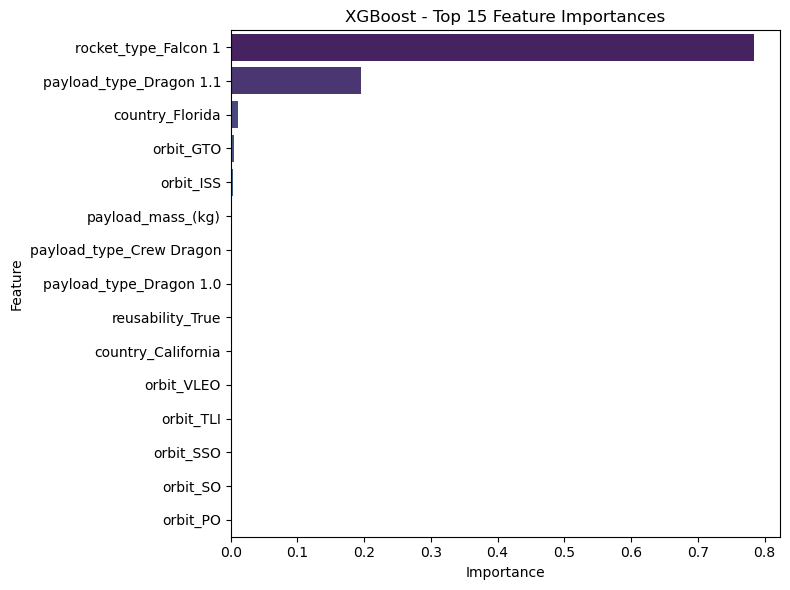

In [49]:
plot_conf_matrix(confusion_matrix(y_test, y_pred_xgb), "XGBoost")
plot_roc_curve(xgb_model, X_test, y_test, "XGBoost")
plot_feature_importance(xgb_model, preprocessor, "XGBoost")

- The plot shows the ROC curve for an XGBoost classifier with an AUC of 0.99.  
- An AUC of 0.99 indicates near-perfect performance in distinguishing between positive and negative classes.  
- The curve hugs the top-left corner, reflecting extremely high true positive rates with very low false positives.

In [50]:
boosting_results.append({
    'Model': 'XGBoost',
    'Accuracy': xgb_model.score(X_test, y_test),
    'AUC': roc_auc_score(y_test, y_pred_xgb)
})

In [51]:
### 2. AdaBoost
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train, y_train)
y_pred_ada = ada_model.predict(X_test)

c:\Users\dhyan\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [52]:
print("\n AdaBoost Results:")
print(confusion_matrix(y_test, y_pred_ada))
print(classification_report(y_test, y_pred_ada))
print("ROC AUC:", roc_auc_score(y_test, y_pred_ada))


 AdaBoost Results:
[[30  2]
 [ 1 31]]
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95        32
         1.0       0.94      0.97      0.95        32

    accuracy                           0.95        64
   macro avg       0.95      0.95      0.95        64
weighted avg       0.95      0.95      0.95        64

ROC AUC: 0.953125


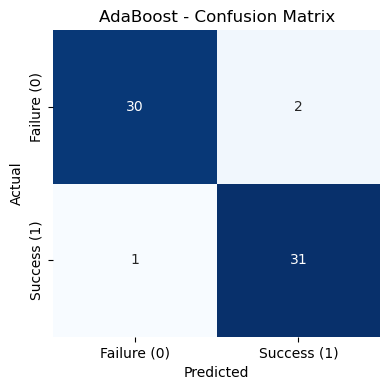

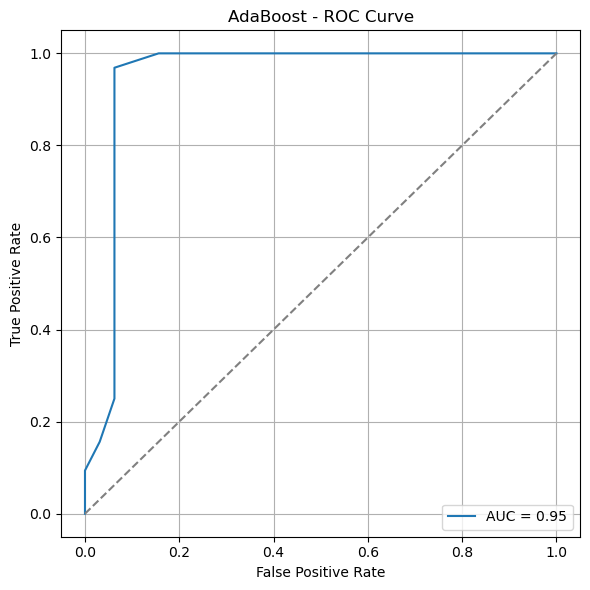

C:\Users\dhyan\AppData\Local\Temp\ipykernel_13844\1161178519.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x='importance', y='feature', palette='viridis')


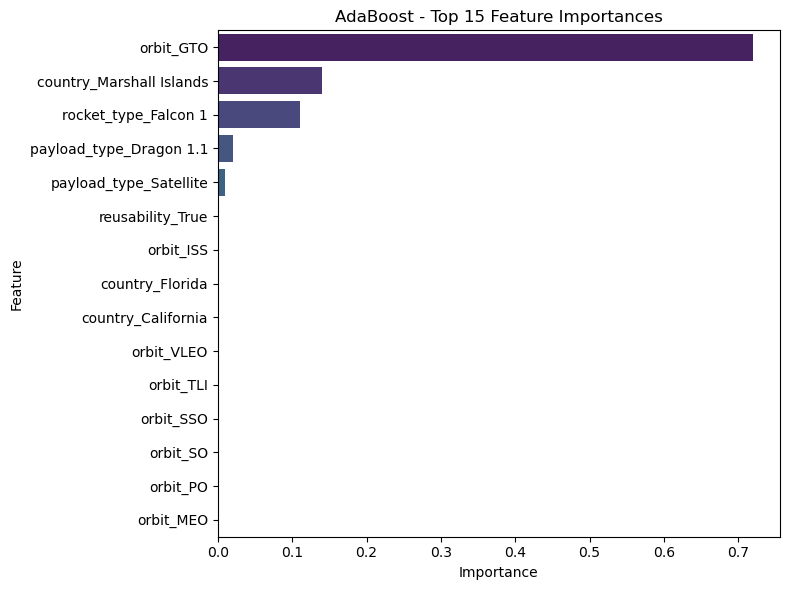

In [53]:
plot_conf_matrix(confusion_matrix(y_test, y_pred_ada), "AdaBoost")
plot_roc_curve(ada_model, X_test, y_test, "AdaBoost")
plot_feature_importance(ada_model, preprocessor, "AdaBoost")

- The plot shows the ROC curve for an AdaBoost classifier with an AUC of 0.95.  
- An AUC of 0.95 indicates very strong performance in distinguishing between the two classes.  
- The steep rise of the curve near the y-axis reflects high sensitivity with minimal false positives.

In [54]:
boosting_results.append({
    'Model': 'AdaBoost',
    'Accuracy': ada_model.score(X_test, y_test),
    'AUC': roc_auc_score(y_test, y_pred_ada)
})


In [55]:
### 3. Light GBM
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)

[LightGBM] [Info] Number of positive: 127, number of negative: 127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 254, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Users\dhyan\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\dhyan\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\dhyan\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dhyan\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\dhyan\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

In [56]:
print("\n LightGBM Results:")
print(confusion_matrix(y_test, y_pred_lgbm))
print(classification_report(y_test, y_pred_lgbm))
print("ROC AUC:", roc_auc_score(y_test, y_pred_lgbm))



 LightGBM Results:
[[31  1]
 [ 1 31]]
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        32
         1.0       0.97      0.97      0.97        32

    accuracy                           0.97        64
   macro avg       0.97      0.97      0.97        64
weighted avg       0.97      0.97      0.97        64

ROC AUC: 0.96875


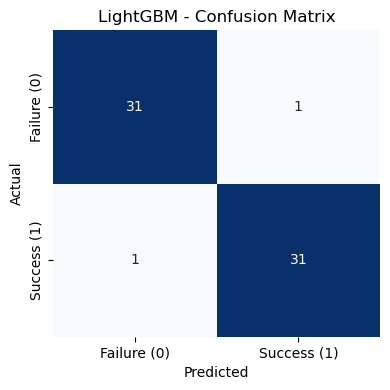

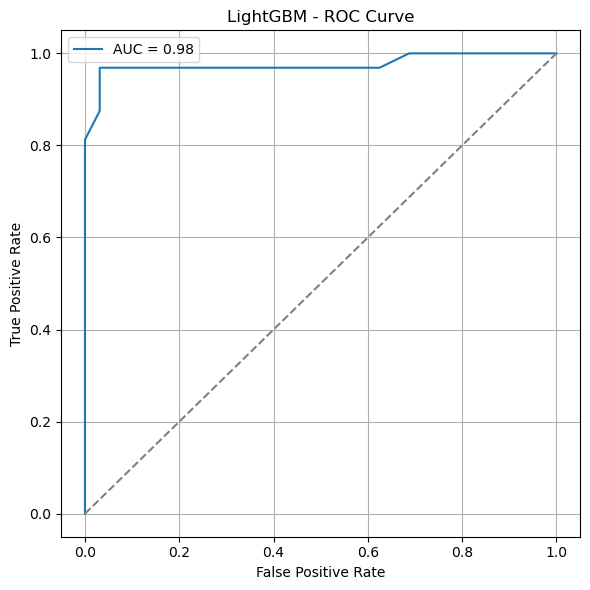

C:\Users\dhyan\AppData\Local\Temp\ipykernel_13844\1161178519.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x='importance', y='feature', palette='viridis')


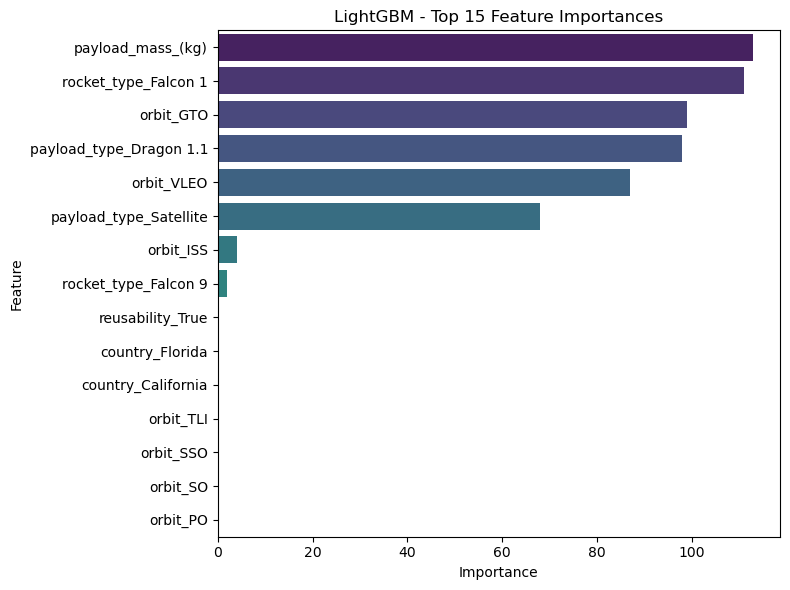

In [57]:
plot_conf_matrix(confusion_matrix(y_test, y_pred_lgbm), "LightGBM")
plot_roc_curve(lgbm_model, X_test, y_test, "LightGBM")
plot_feature_importance(lgbm_model, preprocessor, "LightGBM")


-  The ROC curve for LightGBM shows near-perfect separation between classes.  
-  The curve tightly hugs the top-left, indicating excellent sensitivity and specificity.  
-  With an AUC of **0.98**, LightGBM delivers the **best classification performance** among all models evaluated.  

In [58]:
boosting_results.append({
    'Model': 'LightGBM',
    'Accuracy': lgbm_model.score(X_test, y_test),
    'AUC': roc_auc_score(y_test, y_pred_lgbm)
})

## Model Comparison

| Model               | True Negative (TN) | False Positive (FP) | False Negative (FN) | True Positive (TP) | Accuracy  | Comment                                               |
|---------------------|--------------------|----------------------|----------------------|--------------------|-----------|--------------------------------------------------------|
| LightGBM            | 31                 | 1                    | 1                    | 31                 | 96.88%    | Best overall — lowest FP/FN, most balanced          |
| XGBoost             | 30                 | 2                    | 1                    | 31                 | 95.31%    | High accuracy, very few mistakes                       |
| AdaBoost            | 30                 | 2                    | 1                    | 31                 | 95.31%    | Performs identically to XGBoost                        |
| Random Forest       | 29                 | 3                    | 1                    | 31                 | 93.75%    | Strong performance, slightly more FP than boosting     |
| Decision Tree       | 29                 | 3                    | 1                    | 31                 | 93.75%    | Matches RF but more prone to overfitting               |
| Logistic Regression | 23                 | 9                    | 3                    | 29                 | 81.25%    | Higher FP → overpredicts launch success                |
| Ridge Classifier    | 19                 | 13                   | 8                    | 24                 | 67.19%    | Weakest — high misclassification on both classes     |


In [132]:
model_preds = {
    "Logistic Regression": y_pred_log,
    "Ridge Classifier": y_pred_ridge,
    "Decision Tree": y_pred_dt,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb,
    "AdaBoost": y_pred_ada,
    "LightGBM": y_pred_lgbm
}

for model_name, preds in model_preds.items():
    save_conf_matrix(y_test, preds, model_name)


✅ Saved: logistic_regression_confusion_matrix.png
✅ Saved: ridge_classifier_confusion_matrix.png
✅ Saved: decision_tree_confusion_matrix.png
✅ Saved: random_forest_confusion_matrix.png
✅ Saved: xgboost_confusion_matrix.png
✅ Saved: adaboost_confusion_matrix.png
✅ Saved: lightgbm_confusion_matrix.png


In [136]:
def save_roc_curve(model, X_test, y_test, model_name):
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_score = auc(fpr, tpr)

        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title(f'{model_name} - ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        filename = f"{model_name.lower().replace(' ', '_')}_roc_curve.png"
        plt.savefig(filename)
        plt.close()
        print(f"Saved: {filename}")
    except Exception as e:
        print(f" Could not save ROC for {model_name}: {e}")



In [135]:
def save_feature_importance(model, preprocessor, model_name):
    try:
        ohe_features = preprocessor.named_transformers_['cat'].get_feature_names_out()
        full_features = numeric_cols + list(ohe_features)
        importances = model.feature_importances_

        feat_imp_df = pd.DataFrame({'feature': full_features, 'importance': importances})
        feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False).head(15)

        plt.figure(figsize=(8, 6))
        sns.barplot(data=feat_imp_df, x='importance', y='feature', palette='viridis')
        plt.title(f'{model_name} - Feature Importances')
        plt.tight_layout()
        filename = f"{model_name.lower().replace(' ', '_')}_feature_importance.png"
        plt.savefig(filename)
        plt.close()
        print(f"Saved: {filename}")
    except Exception as e:
        print(f"Could not save feature importance for {model_name}: {e}")


In [137]:
model_preds = {
    "Logistic Regression": (log_model, y_pred_log),
    "Ridge Classifier": (ridge_model, y_pred_ridge),
    "Decision Tree": (dt_model, y_pred_dt),
    "Random Forest": (rf_model, y_pred_rf),
    "XGBoost": (xgb_model, y_pred_xgb),
    "AdaBoost": (ada_model, y_pred_ada),
    "LightGBM": (lgbm_model, y_pred_lgbm)
}

for model_name, (model, y_pred) in model_preds.items():
    if model_name != "Ridge Classifier":
        save_roc_curve(model, X_test, y_test, model_name)

    if hasattr(model, "feature_importances_"):
        save_feature_importance(model, preprocessor, model_name)


Saved: logistic_regression_roc_curve.png
Saved: decision_tree_roc_curve.png


C:\Users\dhyan\AppData\Local\Temp\ipykernel_13152\3053170407.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x='importance', y='feature', palette='viridis')


Saved: decision_tree_feature_importance.png
Saved: random_forest_roc_curve.png


C:\Users\dhyan\AppData\Local\Temp\ipykernel_13152\3053170407.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x='importance', y='feature', palette='viridis')


Saved: random_forest_feature_importance.png
Saved: xgboost_roc_curve.png


C:\Users\dhyan\AppData\Local\Temp\ipykernel_13152\3053170407.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x='importance', y='feature', palette='viridis')


Saved: xgboost_feature_importance.png
Saved: adaboost_roc_curve.png


C:\Users\dhyan\AppData\Local\Temp\ipykernel_13152\3053170407.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x='importance', y='feature', palette='viridis')


Saved: adaboost_feature_importance.png
Saved: lightgbm_roc_curve.png


C:\Users\dhyan\AppData\Local\Temp\ipykernel_13152\3053170407.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x='importance', y='feature', palette='viridis')


Saved: lightgbm_feature_importance.png


# Reusability Impact 

### 1. Impact on launch success

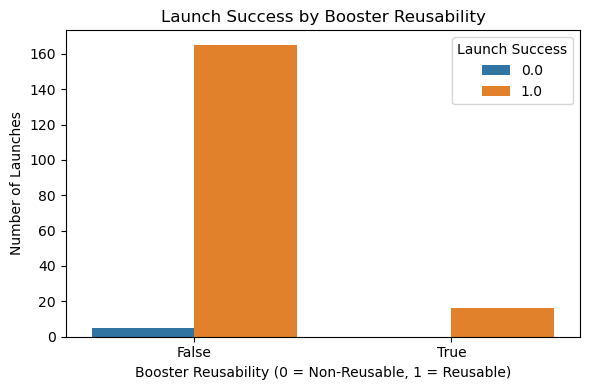

In [61]:
# Success vs Reusability

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='reusability', hue='launch_success')
plt.title('Launch Success by Booster Reusability')
plt.xlabel('Booster Reusability (0 = Non-Reusable, 1 = Reusable)')
plt.ylabel('Number of Launches')
plt.legend(title='Launch Success')
plt.tight_layout()
plt.show()

- The chart compares launch success between reusable and non-reusable boosters.  
- Reusable boosters show a 100% success rate, though they are less frequently used.  
- This suggests that reusability does not compromise reliability and may enhance mission success.  

In [63]:
# Actual success rates
success_rate = df.groupby('reusability')['launch_success'].mean()
print("Success Rate by Reusability:")
print(success_rate)

Success Rate by Reusability:
reusability
False    0.970588
True     1.000000
Name: launch_success, dtype: float64


- Reusable boosters had no recorded failures in dataset, while non-reusable boosters had a small failure rate (~3%). 
- This supports the idea that reusability is at least as reliable as traditional one-time-use systems.

### 2. Impact on Payload Performance

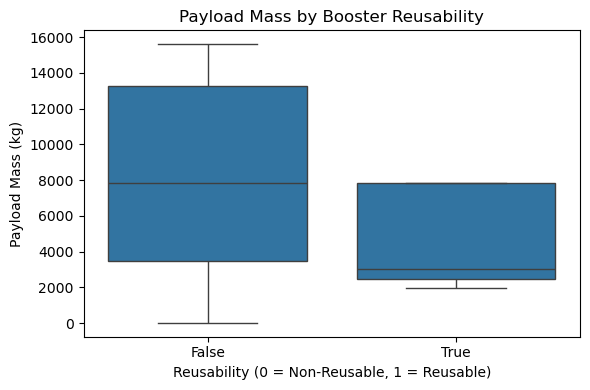

In [65]:
# Payload mass distributions
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='reusability', y='payload_mass_(kg)')
plt.title('Payload Mass by Booster Reusability')
plt.xlabel('Reusability (0 = Non-Reusable, 1 = Reusable)')
plt.ylabel('Payload Mass (kg)')
plt.tight_layout()
plt.show()

In [68]:
from scipy.stats import ttest_ind

reusable_payloads = df[df['reusability'] == True]['payload_mass_(kg)'].dropna()
non_reusable_payloads = df[df['reusability'] == False]['payload_mass_(kg)'].dropna()

t_stat, p_val = ttest_ind(reusable_payloads, non_reusable_payloads, equal_var=False)
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value    : {p_val:.4f}")

T-statistic: -4.4935
P-value    : 0.0001


- Reusability is associated with a reduction in payload mass.  
- Reusable boosters consistently carry lighter payloads compared to non-reusable ones.  
- The difference is statistically significant (p = 0.0001), suggesting that current reusable technology may involve performance trade-offs.  

### 3. Reusability Trend

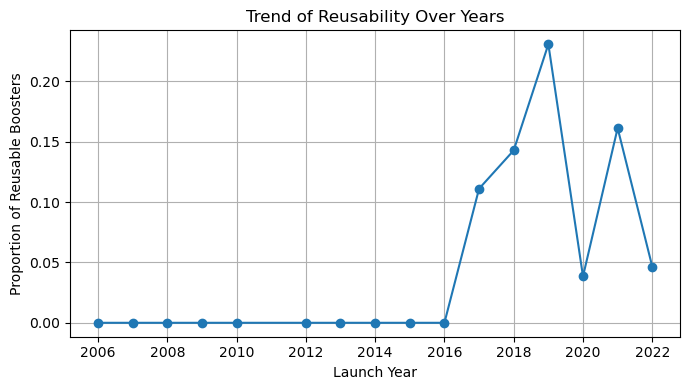

In [69]:
reusability_trend = df.groupby('launch_year')['reusability'].mean()

# Plot
plt.figure(figsize=(7, 4))
reusability_trend.plot(marker='o')
plt.title('Trend of Reusability Over Years')
plt.xlabel('Launch Year')
plt.ylabel('Proportion of Reusable Boosters')
plt.grid(True)
plt.tight_layout()
plt.show()

- Reusability was absent in launches prior to 2017, with a sharp rise starting that year.  
- The peak occurred around 2019, with over 20% of launches using reusable boosters.  
- While adoption fluctuates, the trend indicates a growing shift toward reusable launch systems.  

### 4. Booster Reuse Count Analysis

In [71]:
# Total reusable launches
total_reusable_launches = df[df['reusability'] == True].shape[0]

# Total launches
total_launches = df.shape[0]

# Reusability percentage
reusability_percent = (total_reusable_launches / total_launches) * 100

print(f"Total launches              : {total_launches}")
print(f"Reusable launches           : {total_reusable_launches}")
print(f"Reusability adoption rate   : {reusability_percent:.2f}%")

Total launches              : 186
Reusable launches           : 16
Reusability adoption rate   : 8.60%


- Out of 186 total launches, only 16 used reusable boosters, resulting in an adoption rate of 8.60%.  
- This indicates that while reusability has been introduced, it still represents a small portion of total launches.  